In [1]:
# to input data 
import numpy as np
import pandas as pd

# to visualize data
import matplotlib.pyplot as plt

# to prepare data
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

from catboost import CatBoostClassifier

## 1. Input Data & Data Analysis

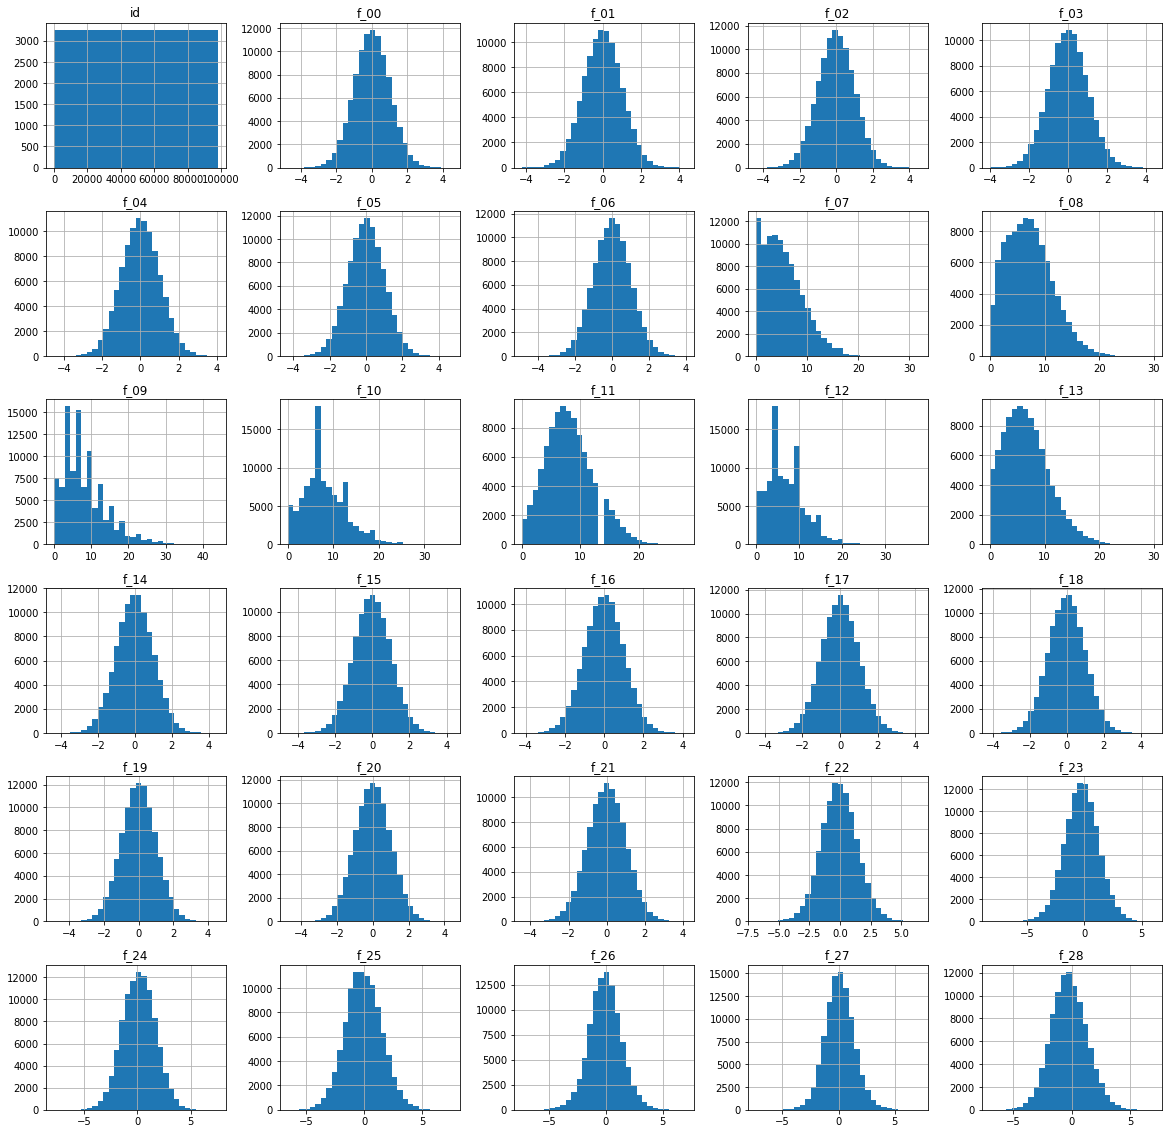

In [2]:
train=pd.read_csv("data/data.csv")

train.hist(figsize=(20, 20), bins=30);

As we can see a lot of graphs have a very similar distribution (f_00 and f_05 for example) therefore, we need to drop unwanted data and leave these columns: f_07, f_08, f_09, f_10, f_11, f_12, f_13, 'f_22', f_23, f_25, 'f_26', 'f_27' and 'f_28'. These data have different distributions and that's very important for training our model.

In [3]:
cols_all = train.columns
cols_best =['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']
cols_drop=[col for col in cols_all if col not in cols_best]

train=train.drop(cols_drop, axis=1)

## 2. Data Preprocessing

Let's check for data types to determine the outliers of numerical data.

In [4]:
train.dtypes

f_07      int64
f_08      int64
f_09      int64
f_10      int64
f_11      int64
f_12      int64
f_13      int64
f_22    float64
f_23    float64
f_24    float64
f_25    float64
f_26    float64
f_27    float64
f_28    float64
dtype: object

Obviously, 'f_23', 'f_24', and 'f_27' are numerical features so we need to cut outliers by means of RobustScaler.

In [5]:
# categorical data
cols_int = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13']
# numerical data
cols_float = [col for col in cols_best if col not in cols_int]

# IQR
def iqr_outliers(df, col_list):
    for col in col_list:
        transformer = RobustScaler()
        df[col] = transformer.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return df

train = iqr_outliers(train, cols_float)

And now we need to scale data and transform our data. And since this data do have negative values, I will use Yeo-Johnson method. These transformations are necessery for normal training of a model otherwise we will waste too much memory during training.

In [6]:
# copy train data
train_scaled=train.copy()
# to make data more Gaussian-like
train_scaled[cols_best]= PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(train_scaled[cols_best])
# scale data
train_scaled[cols_best]= MinMaxScaler().fit_transform(train_scaled[cols_best])

In [7]:
print("Before Transformation:")
display(train.head(2))
print("After Transformation:")
display(train_scaled.head(2))

Before Transformation:


,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,2,13,14,5,13,6,6,-0.529246,0.691952,-0.495728,0.584470,0.758663,0.825922,0.533586
1,2,3,6,4,6,16,9,-0.400787,0.344902,0.750813,-0.083245,-0.429556,0.287253,-1.184987


After Transformation:


,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0.175151,0.588714,0.586435,0.288538,0.576299,0.349190,0.366363,0.446971,0.653336,0.458056,0.571387,0.608211,0.630081,0.588454
1,0.175151,0.208920,0.370471,0.246313,0.321894,0.628359,0.479532,0.465921,0.605345,0.630185,0.472091,0.458150,0.569720,0.333024


## 3. Build and Train Model

Let's find optimal number of cluster of our data to set the hyperparameter in BayesianGaussianMixture. To do this, we will use Elbow Method.

In [8]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(train)
    Sum_of_squared_distances.append(km.inertia_)

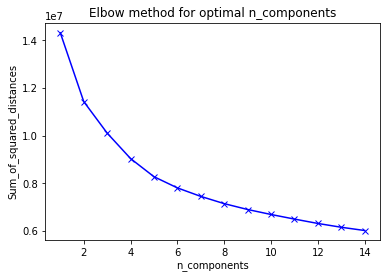

In [9]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('n_components')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow method for optimal n_components')
plt.show()

As can be seen on the graph, our value equals between 6 and 8. Consequently, we will choose 7.

In [10]:
BGM = BayesianGaussianMixture(n_components=7, covariance_type='full', random_state=1)
BGM.fit(train_scaled[cols_best])

predict=BGM.predict(train_scaled[cols_best])
proba=BGM.predict_proba(train_scaled[cols_best])

train_scaled['predict']=predict
train_scaled['predict_proba']=np.max(proba, axis=1) 

train_index=train_scaled[train_scaled.predict_proba > 0.7].index
print(round(len(train_index)/len(train),3))

0.742


Now we found ~75% of predict labels for our data. We will find remaining 25% means by CatBoostClassifier. This is good library for gradient boosting on decision trees that fits well in our case.

In [11]:
X=train_scaled.loc[train_index][cols_best]
y=train_scaled.loc[train_index]['predict']

model = CatBoostClassifier(iterations=1000,
                           depth=7,
                           learning_rate=0.07,
                           loss_function='MultiClassOneVsAll',
                           verbose=True)

model.fit(X,y)

0:	learn: 0.6422386	total: 98.2ms	remaining: 1m 38s
1:	learn: 0.5972418	total: 133ms	remaining: 1m 6s
2:	learn: 0.5587837	total: 171ms	remaining: 56.8s
3:	learn: 0.5238879	total: 211ms	remaining: 52.7s
4:	learn: 0.4924445	total: 251ms	remaining: 49.9s
5:	learn: 0.4646873	total: 287ms	remaining: 47.5s
6:	learn: 0.4391487	total: 322ms	remaining: 45.7s
7:	learn: 0.4156542	total: 360ms	remaining: 44.6s
8:	learn: 0.3947448	total: 399ms	remaining: 43.9s
9:	learn: 0.3752423	total: 435ms	remaining: 43s
10:	learn: 0.3573897	total: 467ms	remaining: 42s
11:	learn: 0.3412407	total: 500ms	remaining: 41.2s
12:	learn: 0.3269831	total: 535ms	remaining: 40.6s
13:	learn: 0.3130366	total: 573ms	remaining: 40.3s
14:	learn: 0.3004928	total: 610ms	remaining: 40s
15:	learn: 0.2889203	total: 651ms	remaining: 40.1s
16:	learn: 0.2778915	total: 685ms	remaining: 39.6s
17:	learn: 0.2679652	total: 719ms	remaining: 39.2s
18:	learn: 0.2590377	total: 752ms	remaining: 38.8s
19:	learn: 0.2504774	total: 794ms	remaining: 

164:	learn: 0.0550892	total: 6.28s	remaining: 31.8s
165:	learn: 0.0548870	total: 6.32s	remaining: 31.8s
166:	learn: 0.0546401	total: 6.36s	remaining: 31.7s
167:	learn: 0.0544107	total: 6.4s	remaining: 31.7s
168:	learn: 0.0541527	total: 6.43s	remaining: 31.6s
169:	learn: 0.0539213	total: 6.47s	remaining: 31.6s
170:	learn: 0.0536348	total: 6.51s	remaining: 31.5s
171:	learn: 0.0533847	total: 6.54s	remaining: 31.5s
172:	learn: 0.0531434	total: 6.58s	remaining: 31.5s
173:	learn: 0.0528761	total: 6.62s	remaining: 31.4s
174:	learn: 0.0525608	total: 6.65s	remaining: 31.4s
175:	learn: 0.0523186	total: 6.68s	remaining: 31.3s
176:	learn: 0.0520869	total: 6.72s	remaining: 31.2s
177:	learn: 0.0518763	total: 6.75s	remaining: 31.2s
178:	learn: 0.0515829	total: 6.79s	remaining: 31.1s
179:	learn: 0.0513266	total: 6.83s	remaining: 31.1s
180:	learn: 0.0511146	total: 6.86s	remaining: 31s
181:	learn: 0.0509352	total: 6.89s	remaining: 31s
182:	learn: 0.0506896	total: 6.93s	remaining: 30.9s
183:	learn: 0.050

326:	learn: 0.0315113	total: 11.7s	remaining: 24.1s
327:	learn: 0.0314404	total: 11.8s	remaining: 24.1s
328:	learn: 0.0313694	total: 11.8s	remaining: 24.1s
329:	learn: 0.0312864	total: 11.8s	remaining: 24s
330:	learn: 0.0312078	total: 11.9s	remaining: 24s
331:	learn: 0.0311259	total: 11.9s	remaining: 23.9s
332:	learn: 0.0311037	total: 11.9s	remaining: 23.9s
333:	learn: 0.0310501	total: 12s	remaining: 23.8s
334:	learn: 0.0309494	total: 12s	remaining: 23.8s
335:	learn: 0.0308777	total: 12s	remaining: 23.8s
336:	learn: 0.0307997	total: 12.1s	remaining: 23.7s
337:	learn: 0.0307173	total: 12.1s	remaining: 23.7s
338:	learn: 0.0306639	total: 12.1s	remaining: 23.6s
339:	learn: 0.0305987	total: 12.1s	remaining: 23.6s
340:	learn: 0.0305270	total: 12.2s	remaining: 23.5s
341:	learn: 0.0304760	total: 12.2s	remaining: 23.5s
342:	learn: 0.0304324	total: 12.2s	remaining: 23.5s
343:	learn: 0.0303777	total: 12.3s	remaining: 23.4s
344:	learn: 0.0303119	total: 12.3s	remaining: 23.4s
345:	learn: 0.0302590	

490:	learn: 0.0231479	total: 17.1s	remaining: 17.7s
491:	learn: 0.0231231	total: 17.1s	remaining: 17.7s
492:	learn: 0.0230979	total: 17.2s	remaining: 17.6s
493:	learn: 0.0230636	total: 17.2s	remaining: 17.6s
494:	learn: 0.0230289	total: 17.2s	remaining: 17.6s
495:	learn: 0.0229860	total: 17.2s	remaining: 17.5s
496:	learn: 0.0229620	total: 17.3s	remaining: 17.5s
497:	learn: 0.0229185	total: 17.3s	remaining: 17.5s
498:	learn: 0.0228929	total: 17.4s	remaining: 17.4s
499:	learn: 0.0228649	total: 17.4s	remaining: 17.4s
500:	learn: 0.0228076	total: 17.4s	remaining: 17.3s
501:	learn: 0.0227742	total: 17.4s	remaining: 17.3s
502:	learn: 0.0227372	total: 17.5s	remaining: 17.3s
503:	learn: 0.0227160	total: 17.5s	remaining: 17.2s
504:	learn: 0.0226685	total: 17.5s	remaining: 17.2s
505:	learn: 0.0226351	total: 17.6s	remaining: 17.2s
506:	learn: 0.0225835	total: 17.6s	remaining: 17.1s
507:	learn: 0.0225542	total: 17.6s	remaining: 17.1s
508:	learn: 0.0225256	total: 17.7s	remaining: 17s
509:	learn: 0.

654:	learn: 0.0185422	total: 22.3s	remaining: 11.8s
655:	learn: 0.0185205	total: 22.4s	remaining: 11.7s
656:	learn: 0.0185016	total: 22.4s	remaining: 11.7s
657:	learn: 0.0184777	total: 22.4s	remaining: 11.7s
658:	learn: 0.0184603	total: 22.4s	remaining: 11.6s
659:	learn: 0.0184462	total: 22.5s	remaining: 11.6s
660:	learn: 0.0184269	total: 22.5s	remaining: 11.5s
661:	learn: 0.0184155	total: 22.5s	remaining: 11.5s
662:	learn: 0.0184015	total: 22.6s	remaining: 11.5s
663:	learn: 0.0183794	total: 22.6s	remaining: 11.4s
664:	learn: 0.0183559	total: 22.6s	remaining: 11.4s
665:	learn: 0.0183358	total: 22.7s	remaining: 11.4s
666:	learn: 0.0183032	total: 22.7s	remaining: 11.3s
667:	learn: 0.0182897	total: 22.7s	remaining: 11.3s
668:	learn: 0.0182708	total: 22.8s	remaining: 11.3s
669:	learn: 0.0182637	total: 22.8s	remaining: 11.2s
670:	learn: 0.0182391	total: 22.8s	remaining: 11.2s
671:	learn: 0.0182181	total: 22.9s	remaining: 11.2s
672:	learn: 0.0181936	total: 22.9s	remaining: 11.1s
673:	learn: 

813:	learn: 0.0157980	total: 27.3s	remaining: 6.25s
814:	learn: 0.0157864	total: 27.4s	remaining: 6.21s
815:	learn: 0.0157763	total: 27.4s	remaining: 6.18s
816:	learn: 0.0157535	total: 27.4s	remaining: 6.14s
817:	learn: 0.0157518	total: 27.5s	remaining: 6.11s
818:	learn: 0.0157327	total: 27.5s	remaining: 6.07s
819:	learn: 0.0157228	total: 27.5s	remaining: 6.04s
820:	learn: 0.0156914	total: 27.5s	remaining: 6s
821:	learn: 0.0156720	total: 27.6s	remaining: 5.97s
822:	learn: 0.0156547	total: 27.6s	remaining: 5.94s
823:	learn: 0.0156377	total: 27.6s	remaining: 5.9s
824:	learn: 0.0156181	total: 27.7s	remaining: 5.87s
825:	learn: 0.0156026	total: 27.7s	remaining: 5.84s
826:	learn: 0.0155890	total: 27.7s	remaining: 5.8s
827:	learn: 0.0155767	total: 27.8s	remaining: 5.77s
828:	learn: 0.0155710	total: 27.8s	remaining: 5.73s
829:	learn: 0.0155531	total: 27.8s	remaining: 5.7s
830:	learn: 0.0155455	total: 27.9s	remaining: 5.67s
831:	learn: 0.0155078	total: 27.9s	remaining: 5.63s
832:	learn: 0.0154

978:	learn: 0.0136811	total: 32.6s	remaining: 700ms
979:	learn: 0.0136697	total: 32.7s	remaining: 667ms
980:	learn: 0.0136542	total: 32.7s	remaining: 634ms
981:	learn: 0.0136476	total: 32.7s	remaining: 600ms
982:	learn: 0.0136274	total: 32.8s	remaining: 567ms
983:	learn: 0.0136132	total: 32.8s	remaining: 533ms
984:	learn: 0.0136010	total: 32.8s	remaining: 500ms
985:	learn: 0.0135826	total: 32.9s	remaining: 467ms
986:	learn: 0.0135613	total: 32.9s	remaining: 433ms
987:	learn: 0.0135497	total: 32.9s	remaining: 400ms
988:	learn: 0.0135456	total: 33s	remaining: 367ms
989:	learn: 0.0135288	total: 33s	remaining: 333ms
990:	learn: 0.0135225	total: 33s	remaining: 300ms
991:	learn: 0.0135095	total: 33.1s	remaining: 267ms
992:	learn: 0.0135026	total: 33.1s	remaining: 233ms
993:	learn: 0.0134938	total: 33.1s	remaining: 200ms
994:	learn: 0.0134828	total: 33.2s	remaining: 167ms
995:	learn: 0.0134807	total: 33.2s	remaining: 133ms
996:	learn: 0.0134685	total: 33.2s	remaining: 100ms
997:	learn: 0.0134

In [12]:
k = model.predict(train_scaled[cols_best])

ss=pd.read_csv("data/sample_submission.csv")
ss['Predicted']=k
ss.to_csv("submission.csv",index=False)
ss.head()

,Id,Predicted
0,0,4
1,1,6
2,2,4
3,3,3
4,4,1


## Score: 0.61536